# Unsupervised Learning

So far in the course we have talked about *supervised* learning. The concept of labelling input data. In the context of computer vision we've looked at classification, object detection, and segmentation. In each of these examples we've had some datasource (images) that have labels associated with them. The goal is then to learn a function to map images to labels (a neural network).

So the question is, can we use neural network when we don't have labels and only have images? Yes, but not in the same way

## Unsupervised Learning Tasks
The key to understanding which applications work for unsupervised learning is to accept that we are just doing supervised learning, but with a few tricks. Fundemantally our algorithms *require* targets, otherwise we can't calculate loss, and therefore gradients. So the question is really, how can we create labels (or targets) from just input images.

Here I'll go over a set of unsupervised learning tasks, and how to trick your systems into doing classification without labels.

## Classic Example - Image Restoration
The first example that is typically shown in unsupervised computer vision is image restoration. This is the task of designing a function which takes in an image, and produces a "better" version of it. Direct examples are noise removal, image inpainting, and super-resolution.

**Noise Removal**:

In noise removal tasks we want to take a noisy image and produce a clean image. What's great about this task is that all we need to do it is a set of clean images.

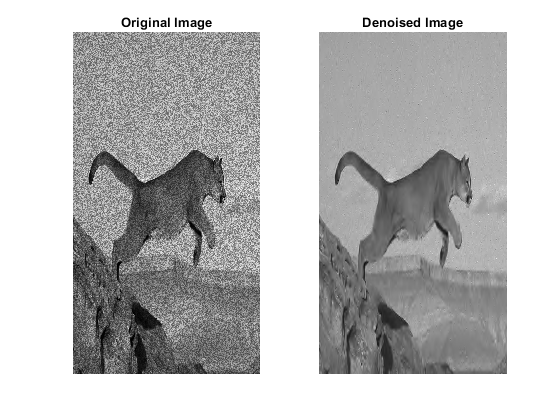


If we understand (roughly) the statistics of our noise model, it is pretty easy to add noise to clean images and then train to recover the original image.

**Image Inpainting**:

Here instead of corrupting our image we can actually *remove* a chunk of it.
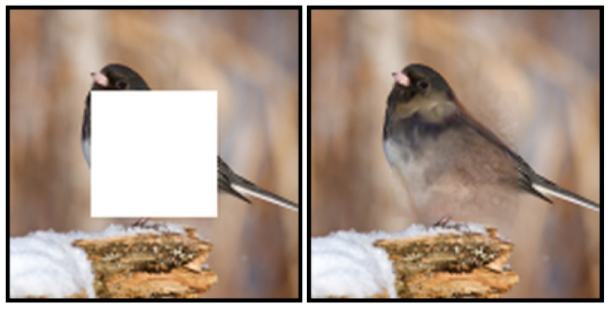

Again all this requires is that you have a decent understanding of how your image may be corrupted in the field and that you have a clean set of images.

**Super Resolution**:

This one is a bit controversal in biomedical imaging...but still interesting!

We are basically taking an input image of a certain resolution and artifically "upsampling" it with a neural network.
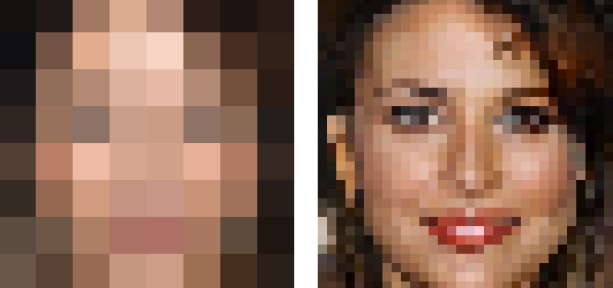

Why is this a problem for biomedical imaging???

## Unsupervised Image Classification -- Autoencoders

When we normally do image classification we learning a relationship directly between images and their labels. What if we took a bit of a different route?
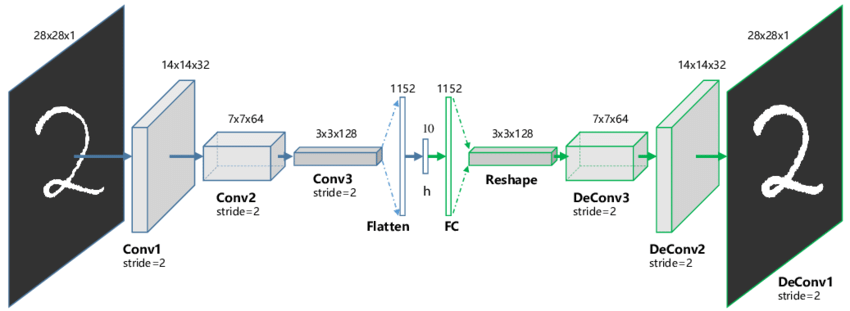


In the example above we have created a neural network which "compresses" an image down to ten dimensions (we call this an embedding). What if we clustered the values of that embedding? It would make a half-decent classifier.

- Note 1: this is also useful if you have very few labelled examples, as you could train an SVM or other lightweight classifier on the embedded space with less data.
- Note 2: this isn't a foolproof mechanism, and fails for certain cases (why?)

# Exercises
We will cover two of these problems, name noise removal and autoencoders for classification.

We will work with the same dataset in both, the white blood cell dataset from HW3.

In [1]:
!wget -O data.zip https://data.mendeley.com/public-files/datasets/snkd93bnjr/files/2fc38728-2ae7-4a62-a857-032af82334c3/file_downloaded
!unzip /content/data.zip  > /dev/null

Streaming output truncated to the last 5000 lines.
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_890863.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_519370.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_215077.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_388154.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_968896.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_34345.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_349907.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_245683.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_785122.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_615525.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_714613.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_904757.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_38351.jpg  
  inflating: PBC_dataset_normal_DIB/erythroblast/ERB_547436.jpg  
  inflating: PBC_dataset_no

(12432, 128, 128, 1) (12432, 8)
(3109, 128, 128, 1) (3109, 8)


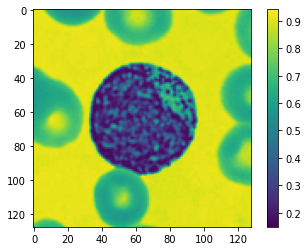

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

def load_and_crop(image_path, crop_size, normalized=True):
    image = Image.open(image_path).resize([200,200])
    width, height = image.size   # Get dimensions
    left = (width - crop_size)/2
    top = (height - crop_size)/2
    right = (width + crop_size)/2
    bottom = (height + crop_size)/2
    # Crop the center of the image
    image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

# code to load all the data, assuming dataset is at PBC_dataset_normal_DIB relative path
cell_types = ['basophil', 'eosinophil', 'erthroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']
cell_inds = np.arange(0, len(cell_types))
x_data = []
y_data = []
for cell_ind in cell_inds:
    all_images = glob.glob(os.path.join('PBC_dataset_normal_DIB', cell_types[cell_ind], '*.jpg'))
    x_data += [load_and_crop(image_path, 128) for image_path in all_images]
    y_data += [cell_ind]*len(all_images)

# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(cell_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(cell_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

# Exercise 1 - Image Denoising

## Exercise 1A - Creating noisy images
With the provided noise statistics create a "noisy" version of the dataset.

Read these docs: https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.random_noise


Apply two noise models in sequence, first Gaussian noise:
- Mean: 0
- Var: 0.1

Then Poisson noise
- Stats generated from images


In [6]:
from skimage.util import random_noise

In [17]:
noise_a = random_noise(x_train, ...)

In [18]:
noise_b = random_noise(noise_a, ...)

## Exercise 1B - Create a U-Net

We will be using the U-Net architecture to de-noise our images. If you completed the bonus exercise from last lab you can re-use your code. Otherwise you can use my version from last lab (linked here: https://colab.research.google.com/drive/1w1ZHFR6r-zpMc5rOot-9AyN4hv8B6bGy?usp=sharing)

**IMPORTANT NOTE**:
Change the architecture to have **1** output channel and have a **sigmoid** activation function.


In [22]:
model = ...

## Exercise 1C - Train your model to do de-noising

- What should the inputs be, what should the outputs be?
- What loss function is appropriate from the provided list:
    - Cosine Similarity
    - Mean Squared Error
    - Binary CrossEntropy
    - Categorical CrossEntropy
    - KLDivergence

Use this information to compile + fit your model. You can leave the optimizer at it's defaults.

In [ ]:
loss_fn = tf.keras.losses....
model.compile(loss=loss_fn)

In [ ]:
model.fit(..., epochs=10, batch_size=32)

## Exercise 1D - Visualize your results

Plot the before/after for three images. Don't worry about test set vs. train set.

# Exercise 2 - Autoencoders for Image Classification

Now we will work with the same dataset and build an auto-encoder to help us classify the images.

This probably won't work super well, so the goal is to get substantially above chance (8-way classification, so chance is 1/8).

In [32]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Dense, Reshape, Flatten
import tensorflow as tf

def create_autoencoder(input_shape):
    input_layer = Input(input_shape)
    x = input_layer
    # down path
    start_filters = 8
    for i in range(4):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**4),3, padding='same', activation='relu')(x)
    x = MaxPool2D()(x)
    x = Flatten()(x)
    x = Dense(8, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Reshape((4,4,64))(x)
    x = UpSampling2D()(x)
    x = Conv2D(start_filters*(2**4),3, padding='same', activation='relu')(x)
    # up path
    for i in range(4):
        x = UpSampling2D()(x)
        x = Conv2D(start_filters*(2**(3-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(3-i)),3, padding='same', activation='relu')(x)
    output = Conv2D(1, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

## Exercise 2A - Create autoencoder

Create an autoencoder using the provided function and identify the bottleneck layer

In [ ]:
autoencoder = ...

## Exercise 2B - Training Autoencoder

Train the autoencoder for 10 epochs, use the same loss function as exercise 1.

In [ ]:
mask = (y_train[:,0] + y_train[:, 1]) > 0
cell_types = y_train[mask]
autoencoder.fit(x_train[mask], x_train[mask], batch_size=32, epochs=10)

## Exercise 2C - Extracting embeddings
Now that we have a trained autoencoder we want to get the embeddings for our images.

Using the name of the layer you identified in 2A, create a new 'embedding' model with the provided code.

Then use that model to generate embeddings for the training set

In [39]:
embedding_model = tf.keras.Model(inputs=autoencoder.input,
                                          outputs=autoencoder.get_layer(layer_name).output)

In [ ]:
embeddings = embedding_model.predict(x_train[mask])

## Exercise 2D - Cluster the embeddings
Now that we have embeddings for each of our images we can use a clustering algorithm to identify groups within the embedding space.

We will use **K-Means**, provided by sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

In [41]:
from sklearn.cluster import KMeans

In [ ]:
n_clusters = ...
kmeans = KMeans(n_clusters=n_clusters).fit(embeddings)
clusters = kmeans.labels_

## Exercise 2E - Compare cluster labels to image labels

Since we don't have a specific order (we don't know which kmeans label is for each image label) you need to check for **consistency** rather than accuracy. Does the clustering algorithm put the right images in the right classes?

Directly we can answer two questions:
1. Within each cell type, how consistent are the cluster labels?
2. Between cell types, how different are the average cluster labels?
    - It's easier to answer this qualitatively so just print the results for each cell type and we will discuss



In [ ]:
cell_types = y_train[mask]
cell_type_2_mask = cell_types[:,1] > 0
cell_type_1_mask = cell_types[:,0] > 0
cluster_1 = clusters[cell_type_1_mask]
cluster_2 = clusters[cell_type_2_mask]